# Sign Language Recognition

## Importing Libraries / Setup / Variables


In [22]:
import random
import numpy as np
from torch import nn
from torch import torch

# Setup Device to run on
device = "cuda" if torch.cuda.is_available() else "cpu"

# Size and number of classes
input_size = 784
num_classes = 26

# Hyperparameters
learning_rate = 0.001
batch_size = 64
num_epochs = 7

# model settings
load_model = True

# Set seeds for reproducibility
seed = 27
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

# Label map
labels_map = {
    0: "A",
    1: "B",
    2: "C",
    3: "D",
    4: "E",
    5: "F",
    6: "G",
    7: "H",
    8: "I",
    9: "J",
    10: "K",
    11: "L",
    12: "M",
    13: "N",
    14: "O",
    15: "P",
    16: "Q",
    17: "R",
    18: "S",
    19: "T",
    20: "U",
    21: "V",
    22: "W",
    23: "X",
    24: "Y",
    25: "Z",
}

## Creating the CNN

Using convolution layers to create filters that detect what kind of sign it should be. Decided against pooling as 28x28 aren't a lot of pixel and information will be lost decreasing this too much. Also using Dropout to prevent over-fitting, but it still seems to over-fit a lot.


In [2]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU()

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 28 * 28, 64)
        self.relu5 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.relu4(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu5(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        return x


model = CNN(in_channels=1, num_classes=num_classes).to(device)

## Different CNN Models and their results


## Loading Data

We setup a transformation for the data. The images will be randomly rotated, flipped, cropped, scaled and translated. Loading the CSVs and setting up a dataLoader.


In [4]:
from torchvision.transforms import v2
from load import ImageDataset
from torch.utils.data import DataLoader

transforms = v2.Compose(
    [
        # v2.RandomRotation(10),
        # v2.RandomHorizontalFlip(),
        # v2.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        # v2.RandomResizedCrop(28, scale=(0.9, 1.1)),
        v2.AutoAugment(),
    ]
)

csv_file_train = "dataset/sign_mnist_train/sign_mnist_train.csv"
csv_file_test = "dataset/sign_mnist_test/sign_mnist_test.csv"
dataset_train = ImageDataset(csv_file_train, transform=transforms)
dataset_test = ImageDataset(csv_file_test)

train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=True)

## Function to evaluate model


In [5]:
def check_accuracy(loader, model, train):
    if train:
        print("Checking accuracy on training data")
    else:
        print("Checking accuracy on test data")

    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        accuracy = float(num_correct) / float(num_samples) * 100
        print(f"Got {num_correct}/{num_samples} with accuracy {accuracy:.2f}%")
    model.train()

## Load model


In [15]:
model_name = "model_auto_augment_mac.pth"

if load_model == True:
    model.load_state_dict(torch.load("saved_models/" + model_name))
    print(f"Model: {model} loaded from file")

Model: CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=100352, out_features=64, bias=True)
  (relu5): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=26, bias=True)
) loaded from file


/var/folders/s3/vf1x2r0x5p7cxm_snmfd4lp40000gn/T/ipykernel_13922/3822370902.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("saved_model

## Train and save model


In [12]:
from torch import optim
from tqdm import tqdm

if not load_model:
    print(f"Model: {model}")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    for epoch in range(num_epochs):
        print(f"Epoch [{epoch + 1}/{num_epochs}]")

        for batch_index, (data, targets) in enumerate(tqdm(train_loader)):
            data = data.to(device)
            targets = targets.to(device)

            # Forward pass
            scores = model(data)
            loss = criterion(scores, targets)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        check_accuracy(train_loader, model, train=True)
        check_accuracy(test_loader, model, train=False)

    torch.save(model.state_dict(), "saved_models/tmp.pth")

Model: CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=100352, out_features=64, bias=True)
  (relu5): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=26, bias=True)
)
Epoch [1/7]


100%|██████████| 429/429 [01:19<00:00,  5.43it/s]


Checking accuracy on training data
Got 19814/27455 with accuracy 72.17%
Checking accuracy on test data
Got 5255/7172 with accuracy 73.27%
Epoch [2/7]


100%|██████████| 429/429 [01:18<00:00,  5.49it/s]


Checking accuracy on training data
Got 23074/27455 with accuracy 84.04%
Checking accuracy on test data
Got 5916/7172 with accuracy 82.49%
Epoch [3/7]


100%|██████████| 429/429 [01:21<00:00,  5.24it/s]


Checking accuracy on training data
Got 24228/27455 with accuracy 88.25%
Checking accuracy on test data
Got 6075/7172 with accuracy 84.70%
Epoch [4/7]


100%|██████████| 429/429 [01:20<00:00,  5.35it/s]


Checking accuracy on training data
Got 25153/27455 with accuracy 91.62%
Checking accuracy on test data
Got 6022/7172 with accuracy 83.97%
Epoch [5/7]


100%|██████████| 429/429 [01:18<00:00,  5.50it/s]


Checking accuracy on training data
Got 25651/27455 with accuracy 93.43%
Checking accuracy on test data
Got 6243/7172 with accuracy 87.05%
Epoch [6/7]


100%|██████████| 429/429 [01:16<00:00,  5.62it/s]


Checking accuracy on training data
Got 25813/27455 with accuracy 94.02%
Checking accuracy on test data
Got 6259/7172 with accuracy 87.27%
Epoch [7/7]


100%|██████████| 429/429 [01:15<00:00,  5.66it/s]


Checking accuracy on training data
Got 26208/27455 with accuracy 95.46%
Checking accuracy on test data
Got 6340/7172 with accuracy 88.40%


## Evaluate model


In [16]:
check_accuracy(train_loader, model, train=True)
check_accuracy(test_loader, model, train=False)

Checking accuracy on training data
Got 26162/27455 with accuracy 95.29%
Checking accuracy on test data
Got 6340/7172 with accuracy 88.40%


### Model Evaluation Results

**Model:** `model_auto_augment_mac.pth`

**Hyperparams:** `learning_rate = 0.001
batch_size = 64
num_epochs = 7 `

```python
CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=100352, out_features=64, bias=True)
  (relu5): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=26, bias=True)
)
```

| Dataset      | Correct Predictions | Total Samples | Accuracy |
| ------------ | ------------------- | ------------- | -------- |
| **Training** | 26,208              | 27,455        | 95.46%   |
| **Test**     | 6,340               | 7,172         | 88.40%   |

- **Training Accuracy:** 95.46%
- **Test Accuracy:** 88.40%

Notes:

- Probably 4/5 Epochs are enough
- Takes a long time to train roughly 13 min on mac
- Complex and deep model


## Analyze results with Gradcam


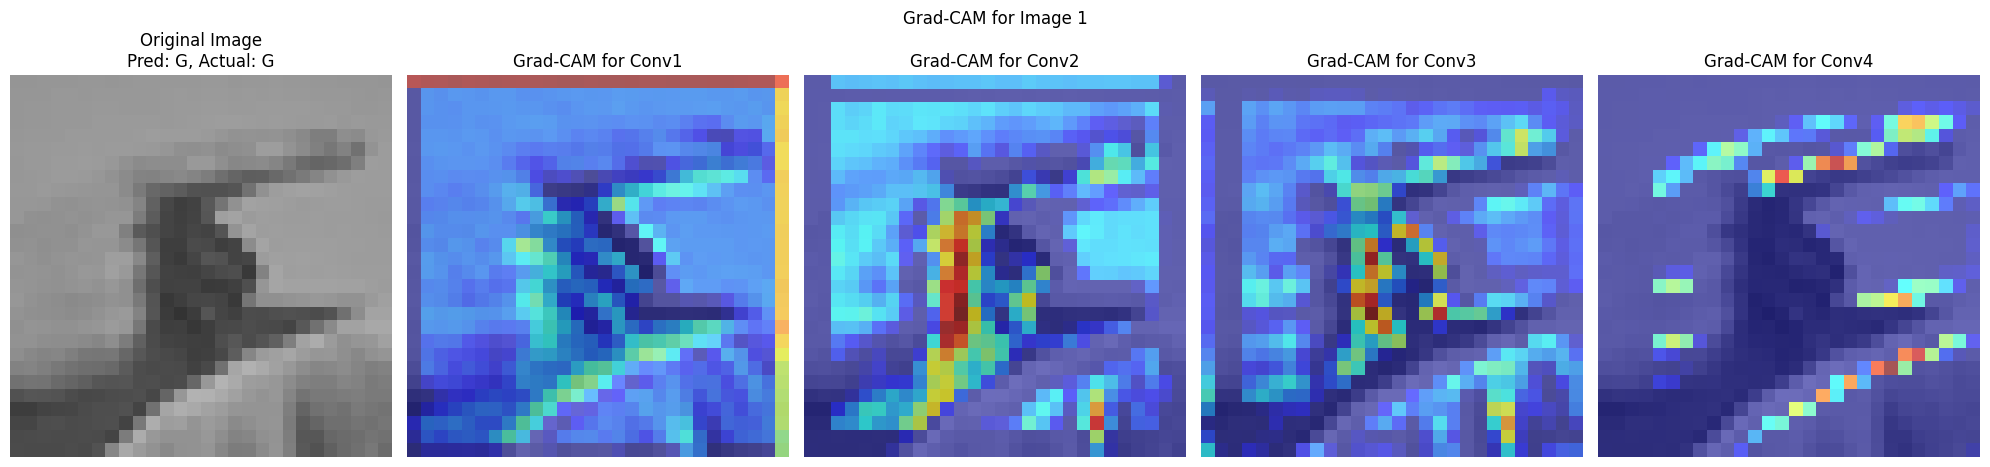

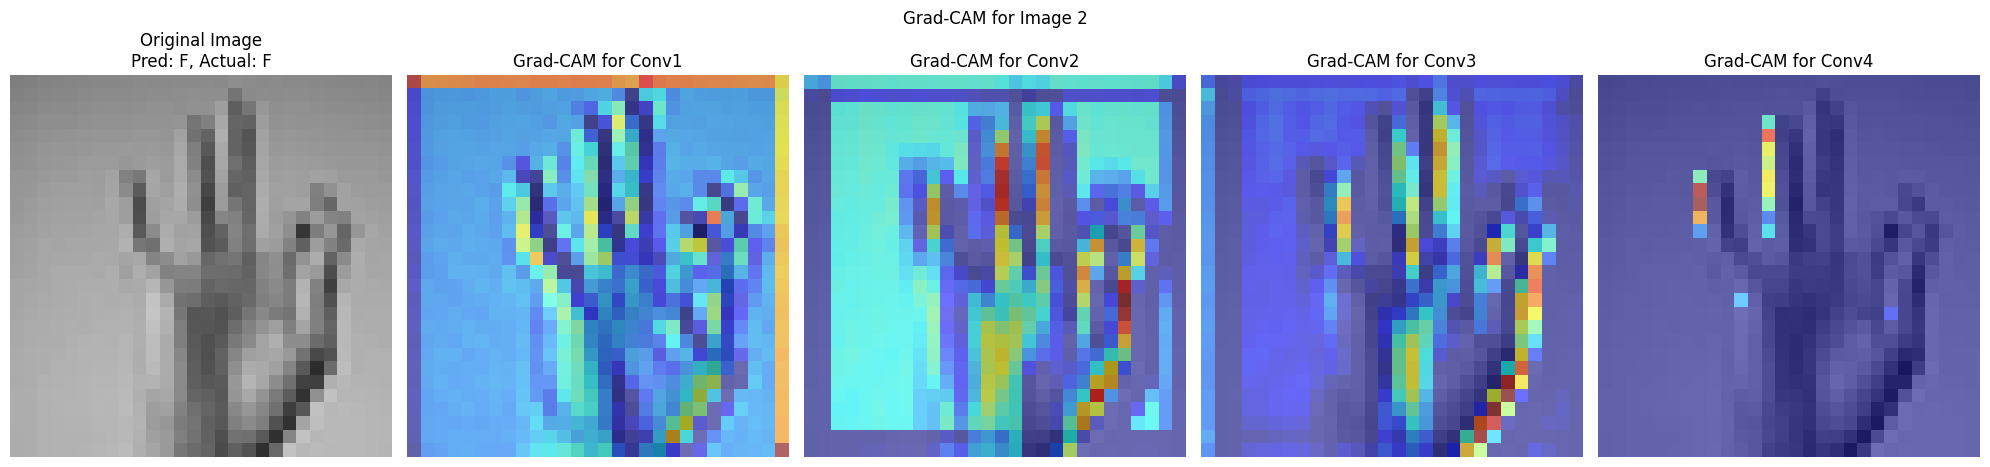

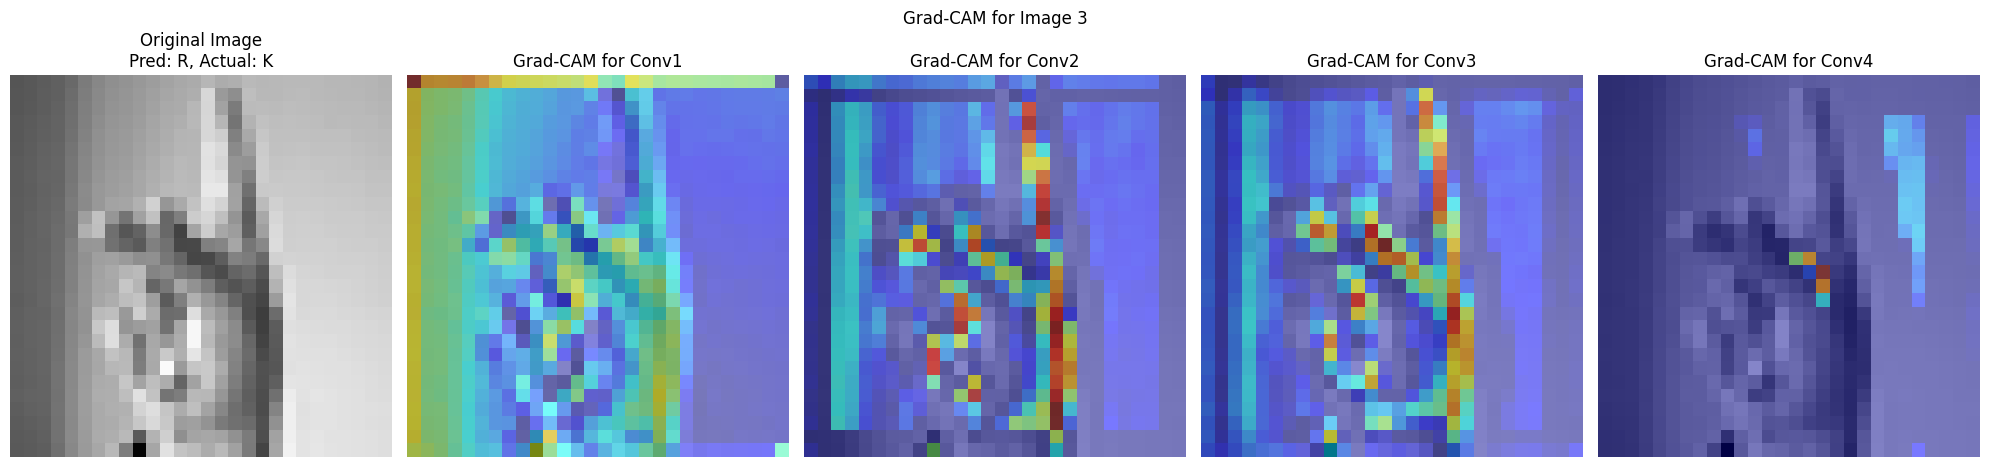

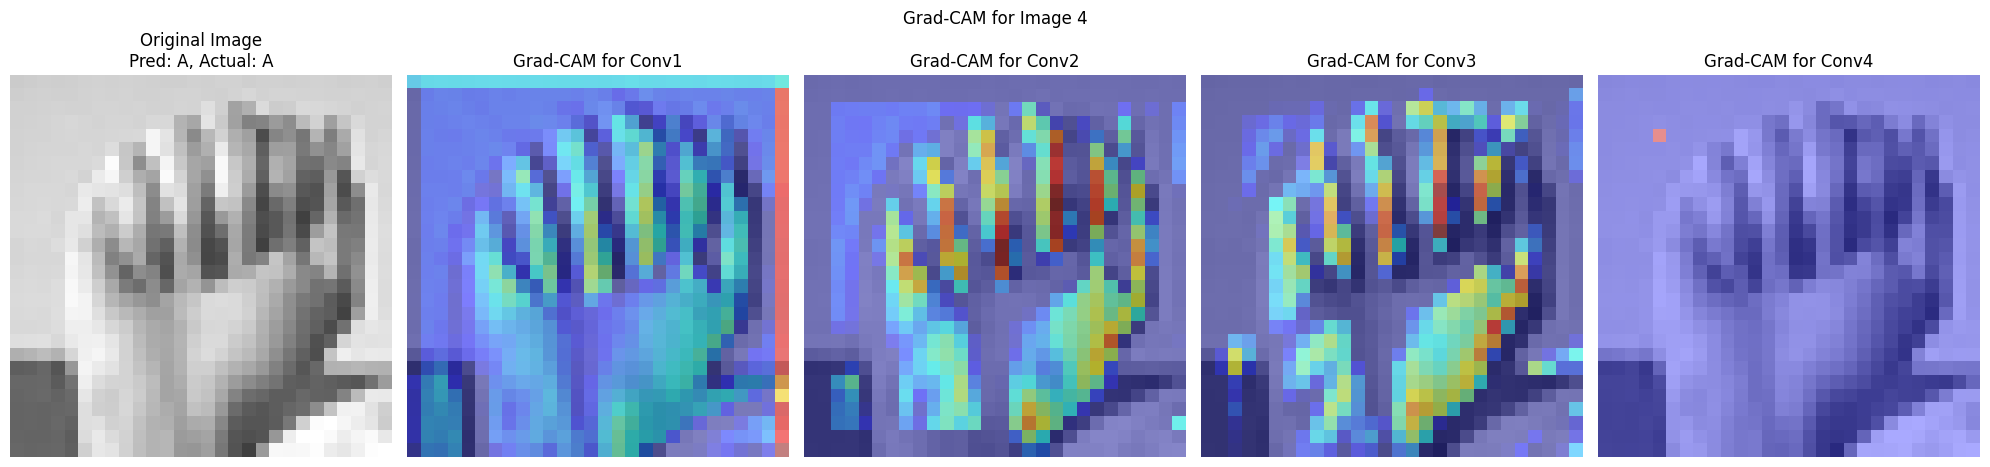

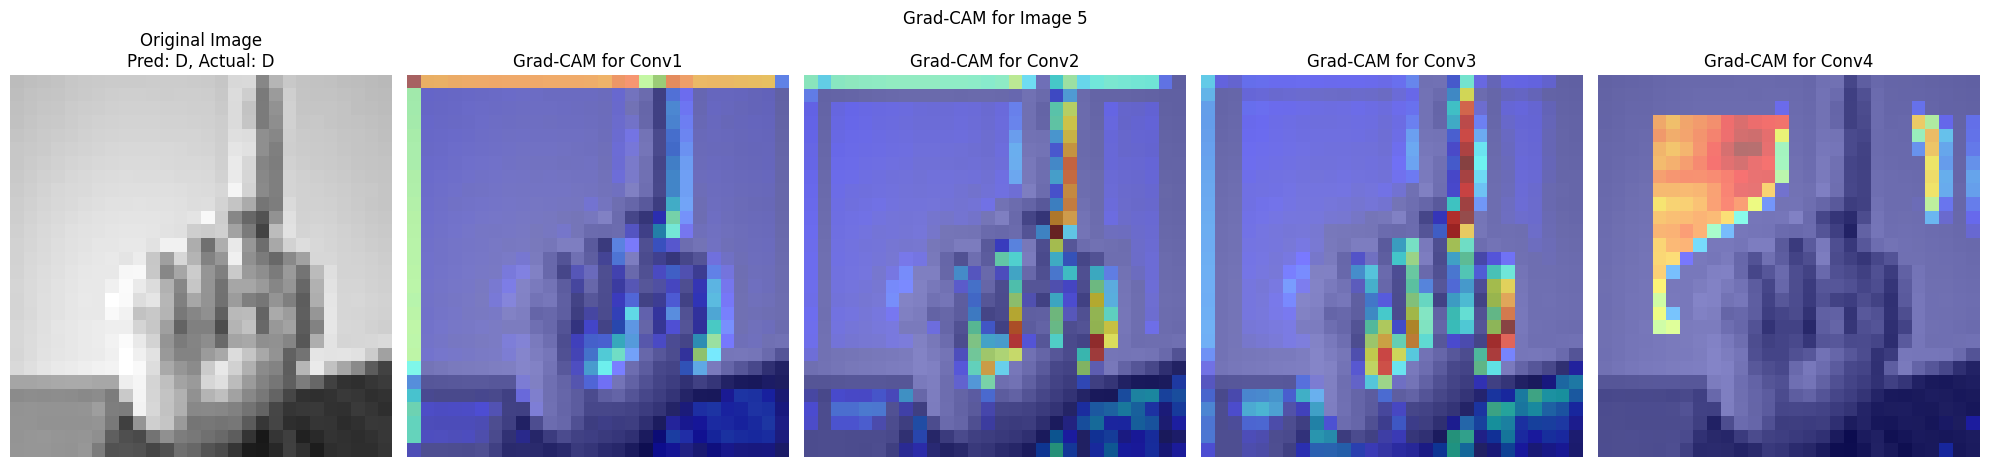

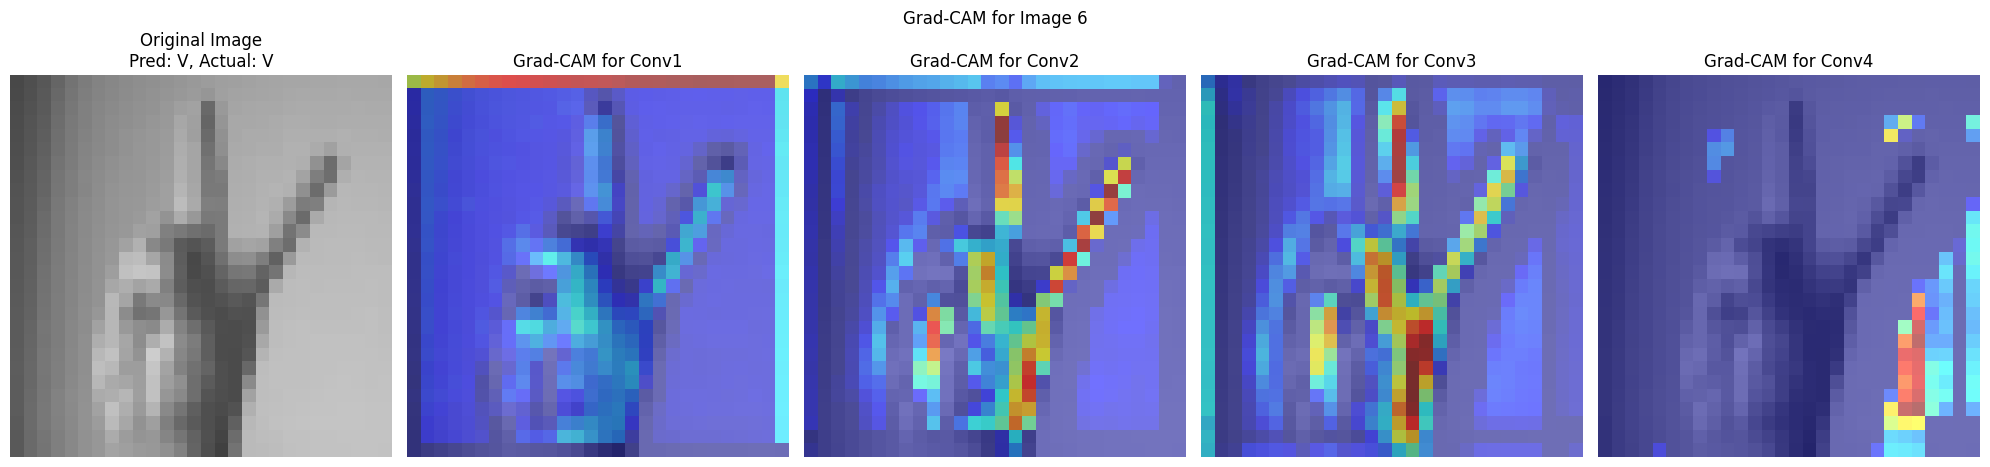

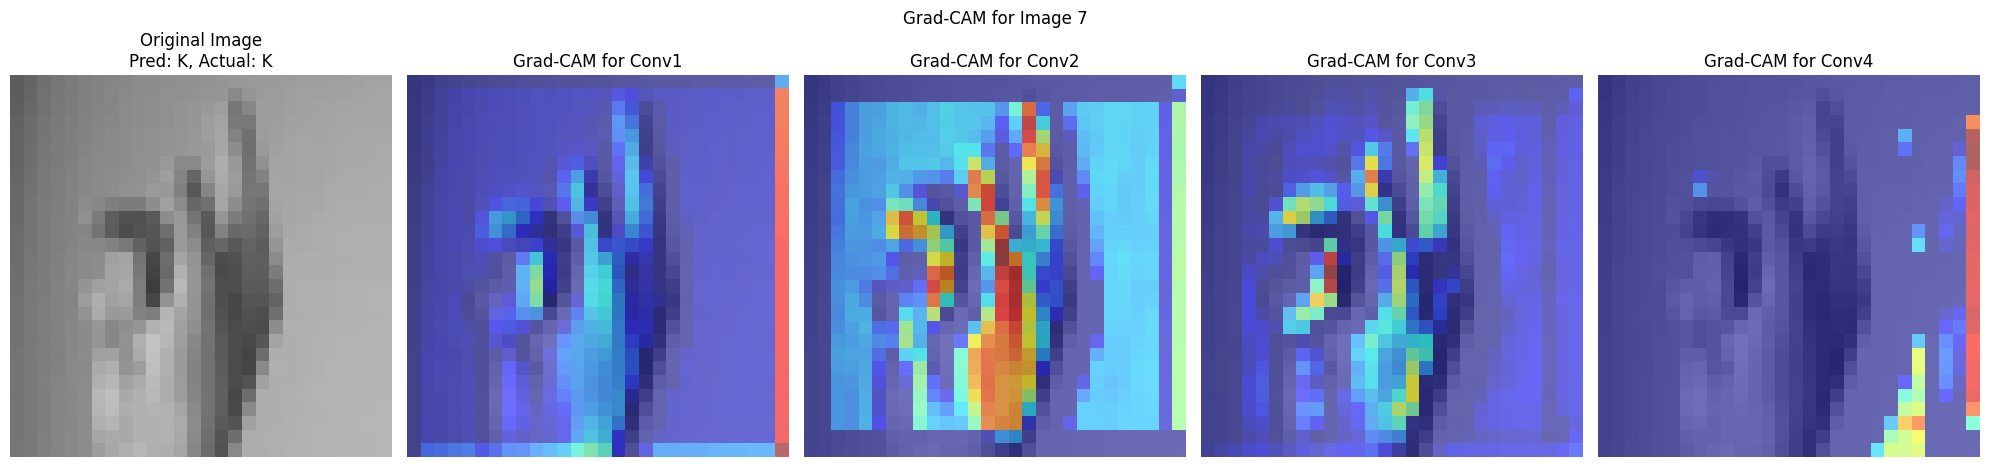

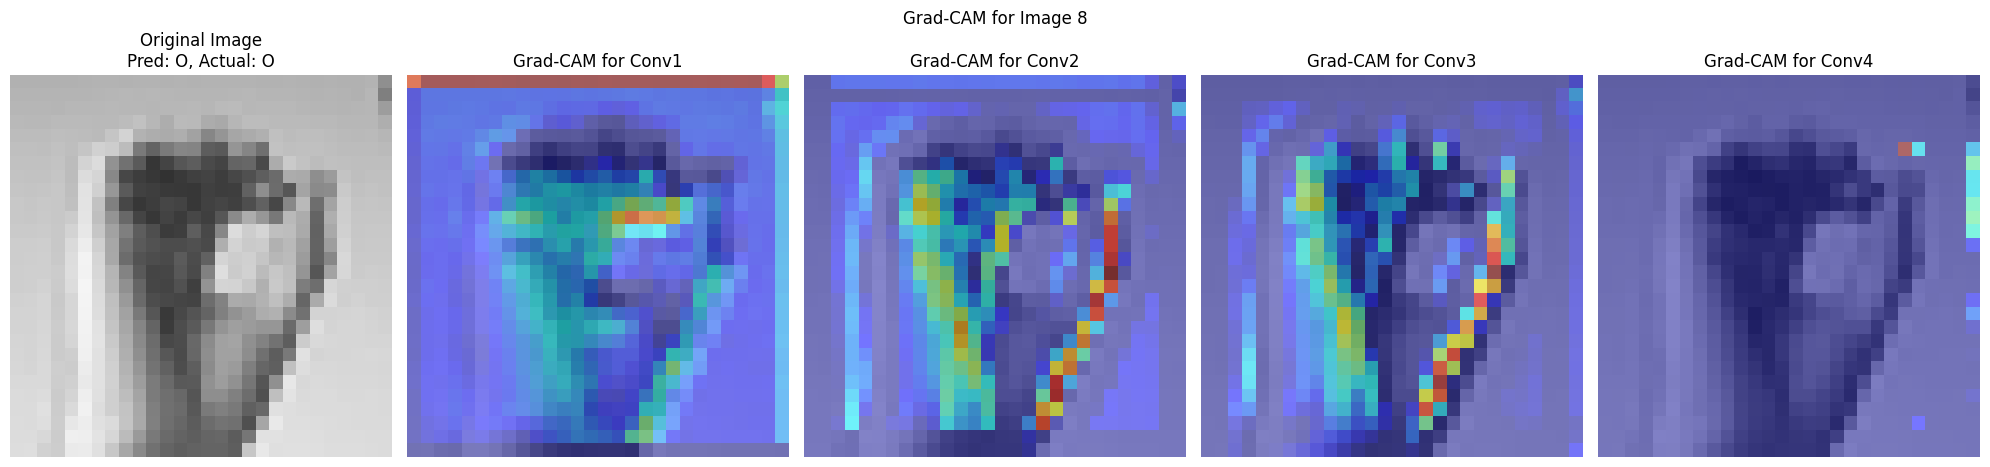

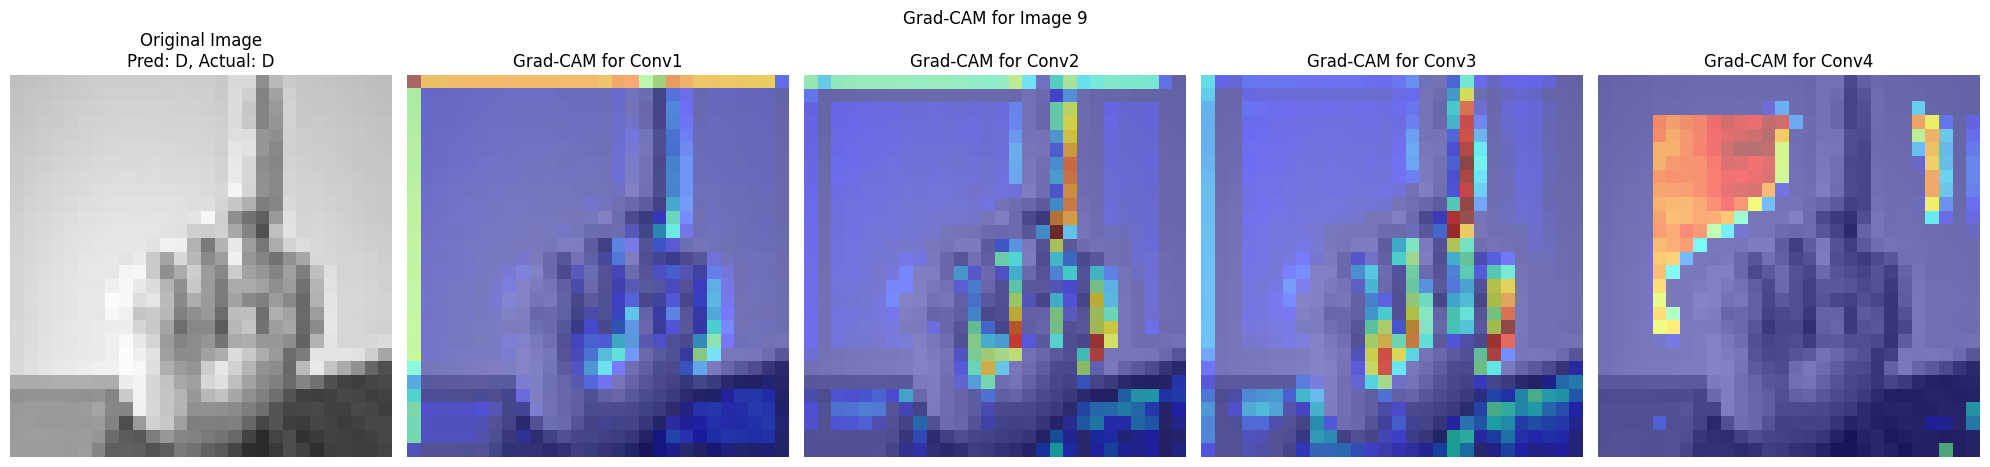

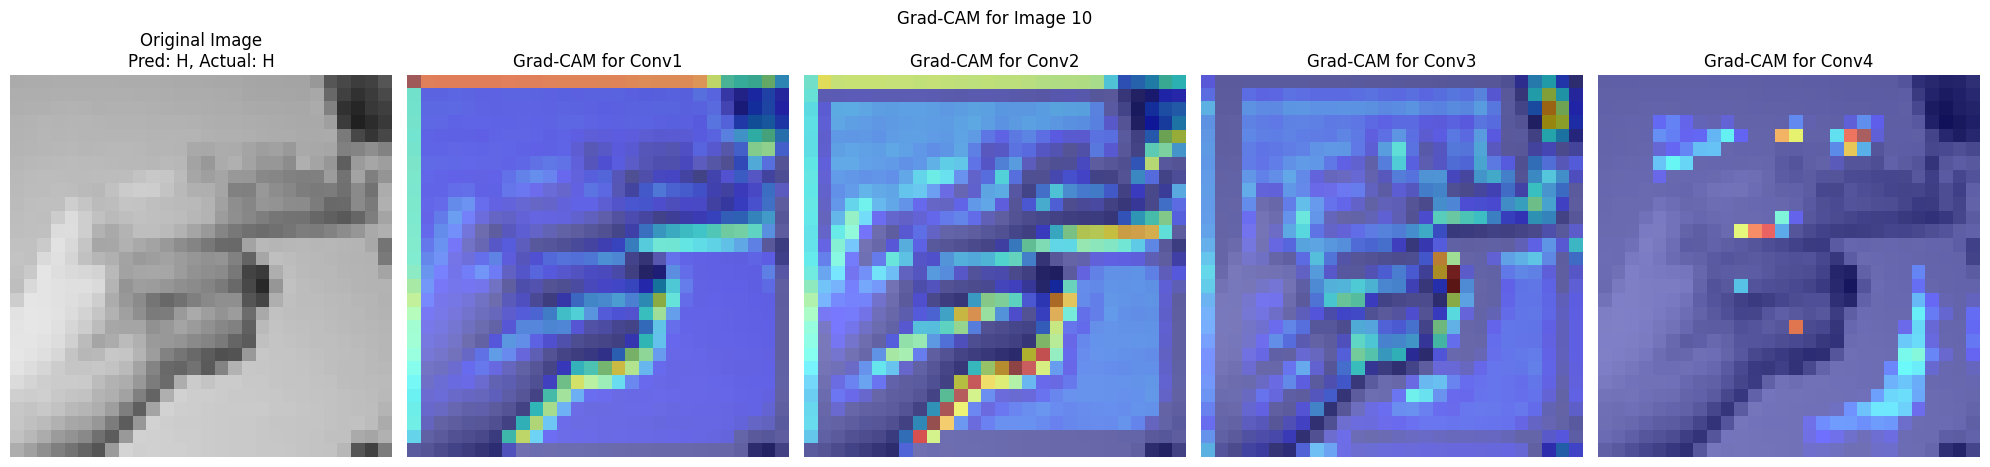

In [32]:
import numpy as np
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import cv2

# target layers for Grad-CAM
target_layers = [layer for layer in model.modules() if isinstance(layer, nn.Conv2d)]

for img_idx in range(10):
    sample_img, sample_label = dataset_test[img_idx]
    sample_img = sample_img.unsqueeze(0).to(device)
    sample_img_pil = to_pil_image(sample_img[0].cpu())

    # Get the predicted class
    output = model(sample_img)
    predicted_class = output.argmax().item()

    # Convert the sample image to RGB for overlay
    rgb_image = np.array(to_pil_image(sample_img[0].cpu())).astype(np.float32) / 255.0
    rgb_image = np.stack([rgb_image] * 3, axis=-1)  # Convert grayscale to RGB

    # Set up the figure to display Grad-CAMs for each layer
    fig, axes = plt.subplots(1, len(target_layers) + 1, figsize=(20, 5))
    axes[0].imshow(rgb_image)
    axes[0].set_title(
        f"Original Image\nPred: {labels_map[predicted_class]}, Actual: {labels_map[sample_label.item()]}"
    )
    axes[0].axis("off")

    for idx, layer in enumerate(target_layers):
        cam = GradCAM(model=model, target_layers=[layer])
        grayscale_cam = cam(input_tensor=sample_img, targets=[ClassifierOutputTarget(predicted_class)])[0]

        # Resize the grayscale CAM to match the size of rgb_image
        grayscale_cam_resized = cv2.resize(grayscale_cam, (rgb_image.shape[1], rgb_image.shape[0]))

        # Expand CAM to 3 channels
        grayscale_cam_resized_3ch = np.repeat(grayscale_cam_resized[:, :, np.newaxis], 3, axis=2)

        # Generate overlay
        cam_image = show_cam_on_image(rgb_image, grayscale_cam_resized_3ch, use_rgb=True)

        # Display the CAM
        axes[idx + 1].imshow(cam_image)
        axes[idx + 1].set_title(f"Grad-CAM for Conv{idx + 1}")
        axes[idx + 1].axis("off")

    plt.suptitle(f"Grad-CAM for Image {img_idx + 1}")
    plt.tight_layout()
    plt.show()
